In [42]:
import numpy as np
import shapely
from shapely.geometry import Polygon
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
import cmocean
import cmocean.cm as cmo
import cmcrameri
import cmcrameri.cm as cmc
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from typing import List, Any
import os
import pandas as pd
from shapely.geometry import Point
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as img
import pyproj

In [43]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

rcoll = sgl.create_roicollection_from_csv(settings18, name = "shackleton")

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
=====> Get ROICollection from csv roi.csv
     | 16 regions created.


In [44]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

In [45]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_10.shp"))

In [46]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [47]:
settings = settings19
coll = coll19
date = "2020-01-22"
roi = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

In [48]:
add = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\add_coastline_high_res_line_v7_6.shp")
add.columns
add["surface"].unique()

shelf_lines = add[add["surface"].isin(['ice shelf and front'])]
grounding_lines = add[add["surface"].isin(['ice coastline', 'grounding line', 'ice rumples', 'rock against ice shelf', 'rock coastline'])]

xmins, ymins, xmaxs, ymaxs = [], [], [], []
for name in coll.names:
    """Tiles"""
    tile = gpd.read_file(os.path.join(settings.region_folder, name + '_shape.shp')).to_crs(pyproj.CRS(settings.crs_ant_str))
    #tile.plot(ax = ax, facecolor="none", alpha = 0.5, edgecolor = "black")
    #ax.text(tile.centroid.x, tile.centroid.y, name.split("-")[-1], rotation = -90, fontweight = "bold")

    """Ice Shelf"""
    xmin, ymin, xmax, ymax = tile.total_bounds
    xmins.append(xmin)
    ymins.append(ymin)
    xmaxs.append(xmax)
    ymaxs.append(ymax)

xmin_total = np.array(xmins).min()
ymin_total = np.array(ymins).min()
xmax_total = np.array(xmaxs).max()
ymax_total = np.array(ymaxs).max()


shelf = shelf_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]
solid = grounding_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]

In [49]:
sample_file = r"D:\[NOT SYNC]\ASRP_Data\shackleton_sgl_20191201_20200331\tile-182_sample.tif"
"""tif"""
with rasterio.open(sample_file) as src:
    meta = src.meta
    tif_clipped, tif_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

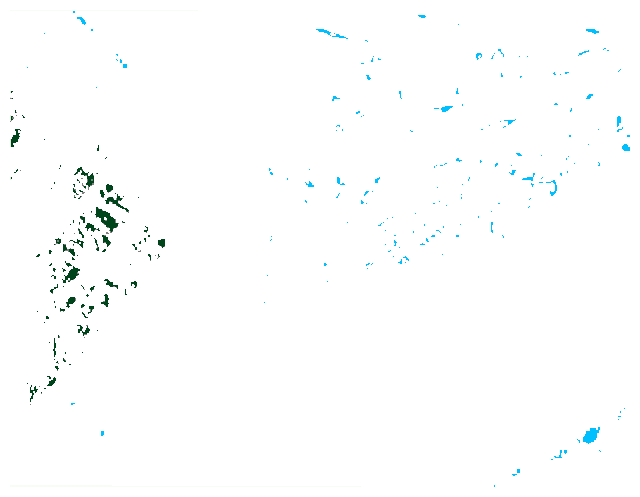

In [50]:
size = 8
dx = tif_clipped.shape[1]
dy = tif_clipped.shape[2]
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(tif_clipped[0], transform = tif_transform, ax = ax, cmap = sgl_utils.cmap_clouds)
rplt.show(-tif_clipped[1], transform = tif_transform, ax = ax, cmap = sgl_utils.cmap_lakes)
rplt.show(tif_clipped[3], transform = tif_transform, ax = ax, cmap = "Greens")
#ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

In [51]:
print(lakeextent18.area.sum())
print(lakeextent19.area.sum())
print(lakeextent20.area.sum())

352455400.0
337309400.0
377092200.0
